In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import griddata
import xarray as xr

In [2]:
# psu, temp, chfa and fdom fluorescence.
# 58.9 – 59.7
# separate file for chl-a

In [3]:
lat1 = 58.9
lat2 = 59.9

## Read data

In [4]:
df = pd.read_csv('FA_2023.csv', parse_dates=['time'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433688 entries, 0 to 433687
Data columns (total 9 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   index                                 433688 non-null  int64         
 1   time                                  433688 non-null  datetime64[ns]
 2   FA/INLET/SBE38/TEMPERATURE/RAW        433688 non-null  float64       
 3   FA/FERRYBOX/SBE45/SALINITY/RAW        433688 non-null  float64       
 4   FA/FERRYBOX/C3/CDOM_FLUORESCENCE/RAW  433688 non-null  float64       
 5   FA/FERRYBOX/C3/CHLA_FLUORESCENCE/RAW  433688 non-null  float64       
 6   FA/FERRYBOX/C3/TURBIDITY/RAW          433688 non-null  float64       
 7   longitude                             433688 non-null  float64       
 8   latitude                              433688 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 29.

In [6]:
df = df[(df['latitude'] >= lat1) & (df['latitude'] <= lat2)]

<Axes: xlabel='longitude', ylabel='latitude'>

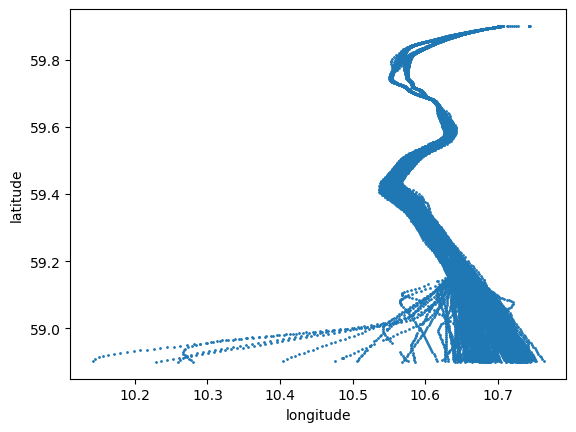

In [7]:
df.plot('longitude', 'latitude', kind='scatter', s=1)

In [8]:
df = df.dropna()

In [9]:
# applying calibration coefficients from Liza
df['FA/FERRYBOX/C3/CHLA_FLUORESCENCE/ADJUSTED'] = df["FA/FERRYBOX/C3/CHLA_FLUORESCENCE/RAW"]* 0.0071 + 0.0635
df['FA/FERRYBOX/C3/CHLA_FLUORESCENCE/CALIBRATED_FROM_SAMPLES'] = df['FA/FERRYBOX/C3/CHLA_FLUORESCENCE/ADJUSTED']*1.0805263363849698 - 0.5340636372805291
 
df['FA/FERRYBOX/C3/CDOM_FLUORESCENCE/ADJUSTED'] = df["FA/FERRYBOX/C3/CDOM_FLUORESCENCE/RAW"]*0.0357 - 0.5162
df['FA/FERRYBOX/C3/CDOM_FLUORESCENCE/SENSOR_ADJUSTED'] = df["FA/FERRYBOX/C3/CDOM_FLUORESCENCE/ADJUSTED"]* 1.6873
 
 
df['FA/FERRYBOX/C3/TURBIDITY/ADJUSTED'] = df["FA/FERRYBOX/C3/TURBIDITY/RAW"]*0.068 - 0.5162
df['FA/FERRYBOX/C3/TURBIDITY/SENSOR_ADJUSTED'] = df["FA/FERRYBOX/C3/TURBIDITY/ADJUSTED"]*1.2426

In [10]:
# save file with applied calibrations
df.to_csv('FA2023_adjusted.csv')

In [11]:
# dictionaries with variables names, colormaps etc
names = ['FA/INLET/SBE38/TEMPERATURE/RAW',
         'FA/FERRYBOX/SBE45/SALINITY/RAW',
         'FA/FERRYBOX/C3/CDOM_FLUORESCENCE/SENSOR_ADJUSTED',
         'FA/FERRYBOX/C3/CHLA_FLUORESCENCE/CALIBRATED_FROM_SAMPLES',
         'FA/FERRYBOX/C3/TURBIDITY/SENSOR_ADJUSTED',]
cmaps = dict(zip(names, ['RdYlBu_r', 'viridis_r',
                         'YlOrBr','YlGn','cividis',]))
labels = dict(zip(names, ['Temperatur, °C', 'Saltholdighet, PSU',
                          'CDOM fluorescens, relativ enhet', 'Klorofyll-a fluorescens, mg/m$^3$', 'Turbiditet, FNU']))
fignames = dict(zip(names, ['Temperatur', 'Saltholdighet',
                            'CDOM fluorescens', 'Klorofyll', 'Turbiditet']))

## Create regular time-lat grid

In [17]:
# original time and lats
tsec = abs((df['time'].iloc[0] - df['time']).dt.total_seconds().to_numpy())/60 # in minutes from beginning
lat = df['latitude'].to_numpy()

In [18]:
# time and lat with regular step
tsec_reg = np.arange(0, tsec[-1], 10) # 10 minutes # WE DIVIDE HERE TO MAKE EUCLIDIAN DISTANCES CLOSER TO EACH OTHER (WITH LAT)
lat_reg = np.linspace(lat1, lat2, 101)

In [20]:
# create 2D grid
tsec_regm, lat_regm = np.meshgrid(tsec_reg,lat_reg)

In [21]:
# create timesteps for plotting interpolated fields
dates = pd.date_range(start=df['time'].iloc[0], freq='10min', periods=tsec_reg.shape[0])

In [22]:
vmaxdict = dict(zip(names, [25, 32, 50, 12, 10]))

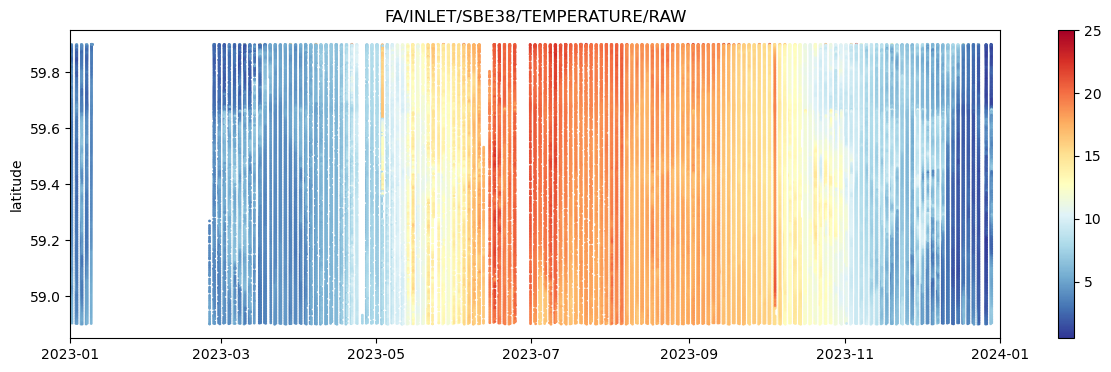

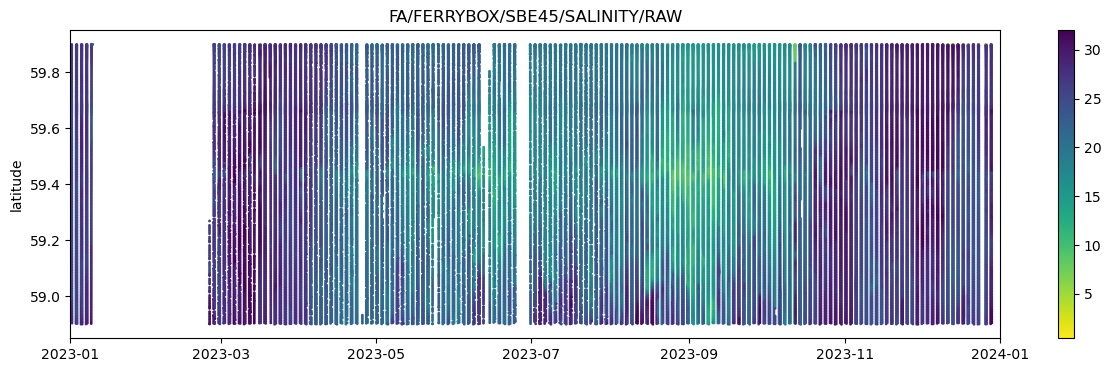

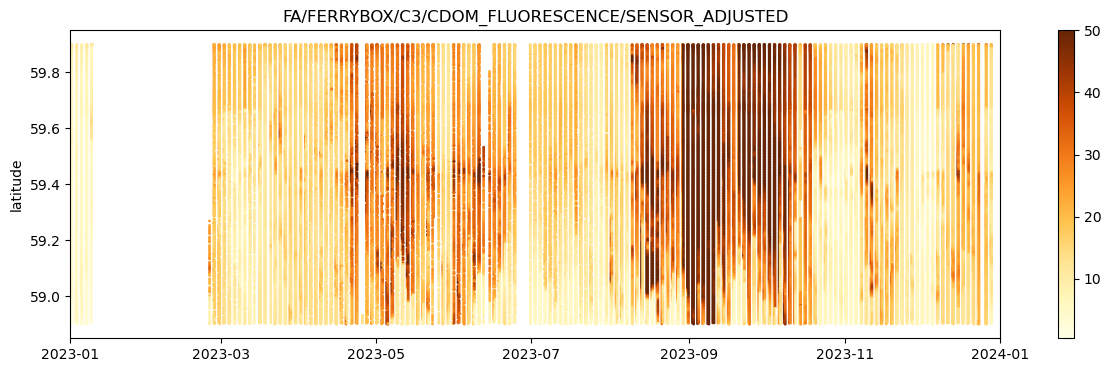

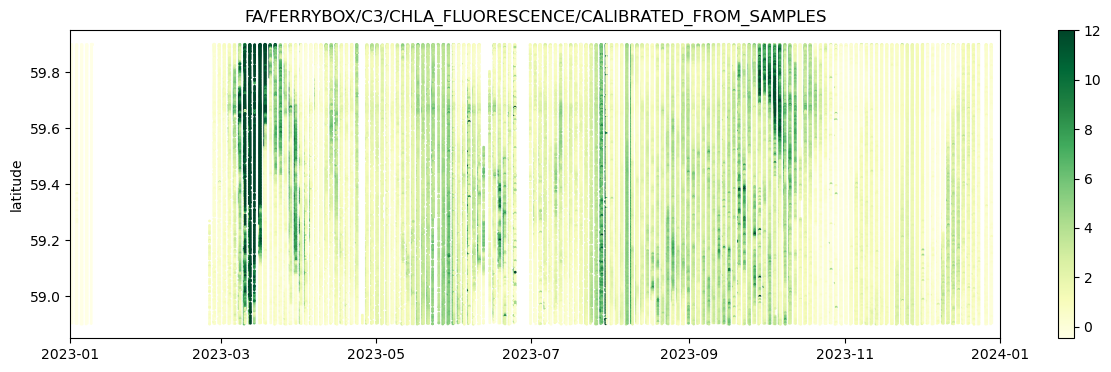

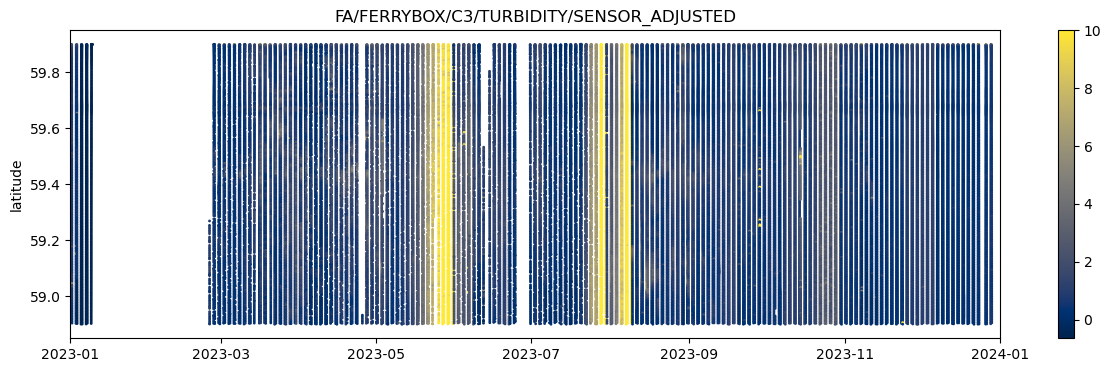

In [24]:
for name in names:
    fig, ax = plt.subplots(figsize=(15,4))
    sc = ax.scatter(df['time'], df['latitude'], c=df[name], s=1, cmap=cmaps[name], vmax=vmaxdict[name])
    ax.set_title(name)
    ax.set_ylabel('latitude')
    
    # ax.text(pd.to_datetime('2023-01-10'), 59.65, 'Drøbak', fontweight='bold', va='center')
    # ax.text(pd.to_datetime('2023-01-10'), 59.55, 'Filtvet', fontweight='bold', va='center')
    # ax.text(pd.to_datetime('2023-01-10'), 59.43, 'Horten', fontweight='bold', va='center')
    # ax.text(pd.to_datetime('2023-01-10'), 59.3, 'Slagen-\ntangen', fontweight='bold', va='center')
    # ax.text(pd.to_datetime('2023-01-10'), 59.1, 'Fuglehuk\nfyr', fontweight='bold', va='center')
    # ax.text(pd.to_datetime('2023-01-10'), 58.93, 'Koster', fontweight='bold', va='center')
    
    cbar = fig.colorbar(sc,) #label=labels[name])
    ax.set_xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2024-01-01'))
    plt.savefig(name[15:].replace("/", "_Outer") + '_original', dpi=300, bbox_inches='tight')

In [25]:
# create xarray dataset (to store interpolated data)
ds = xr.Dataset(coords={'lat': lat_reg, 'datetime': dates})
for name in names:    
    # interpolate variable
    v_reg = griddata((tsec, lat),  # x, y
                     df[name].to_numpy(),  # variable
                     (tsec_regm.ravel(), lat_regm.ravel()),  # Xreg, Yreg
                     method='linear')
    # reshape back to 2D
    vr = v_reg.reshape(tsec_regm.shape)
    # vr[:,mask] = np.nan
    vr = np.clip(vr, 0, vmaxdict[name])
    
    # add interpolated field to dataset
    ds[fignames[name]] = (["lat", "datetime"], vr)

In [26]:
def mask_period(ds, time_periods):
    # Create a boolean mask for each time period and combine them with logical OR
    combined_mask = xr.DataArray(False,
                                 coords={'lat': ds['lat'], 'datetime': ds['datetime']},
                                 dims=['lat', 'datetime'])
    
    for period in time_periods:
        start_date = pd.to_datetime(period['start_date'])
        end_date = pd.to_datetime(period['end_date'])
        mask = (ds['datetime'] >= start_date) & (ds['datetime'] <= end_date)
        combined_mask |= mask
    return combined_mask

In [27]:
# Define multiple time periods you want to set values to NaN
periods_all = [
    {'start_date': '2023-01-10', 'end_date': '2023-02-20'},
]
periods_chl_turb = [
    {'start_date': '2023-07-24', 'end_date': '2023-07-31'},
    {'start_date': '2023-08-04', 'end_date': '2023-08-11'},
    {'start_date': '2023-05-20', 'end_date': '2023-06-01'},
]

mask_all = mask_period(ds, periods_all)
mask_chl_turb = mask_period(ds, periods_chl_turb)

# Set values to NaN based on the combined mask
ds[['Temperatur', 'Saltholdighet', 'CDOM fluorescens', 'Klorofyll', 'Turbiditet']] = ds[['Temperatur', 'Saltholdighet', 'CDOM fluorescens', 'Klorofyll', 'Turbiditet']].where(~mask_all, drop=True)

ds[['Klorofyll', 'Turbiditet', 'CDOM fluorescens']] = ds[['Klorofyll', 'Turbiditet', 'CDOM fluorescens']].where(~mask_chl_turb, drop=True)

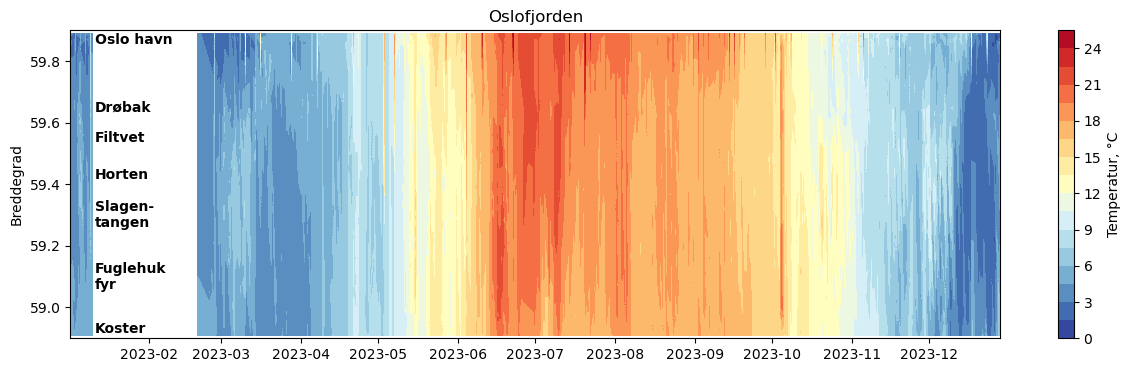

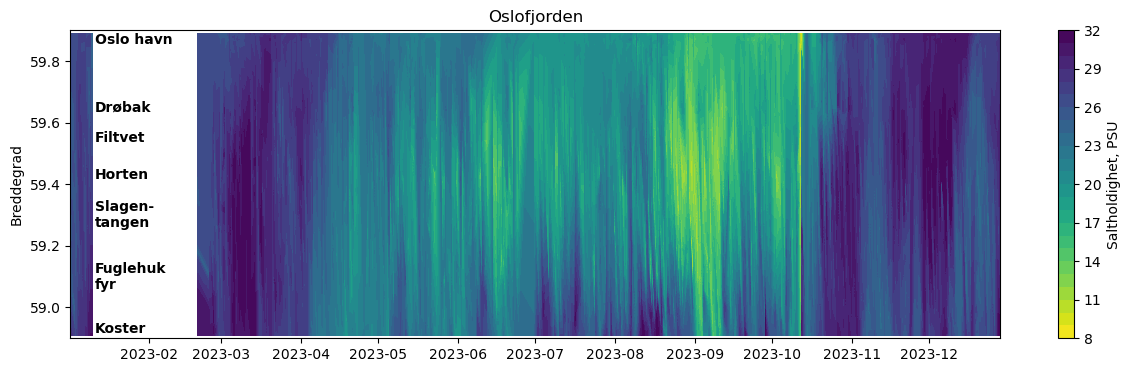

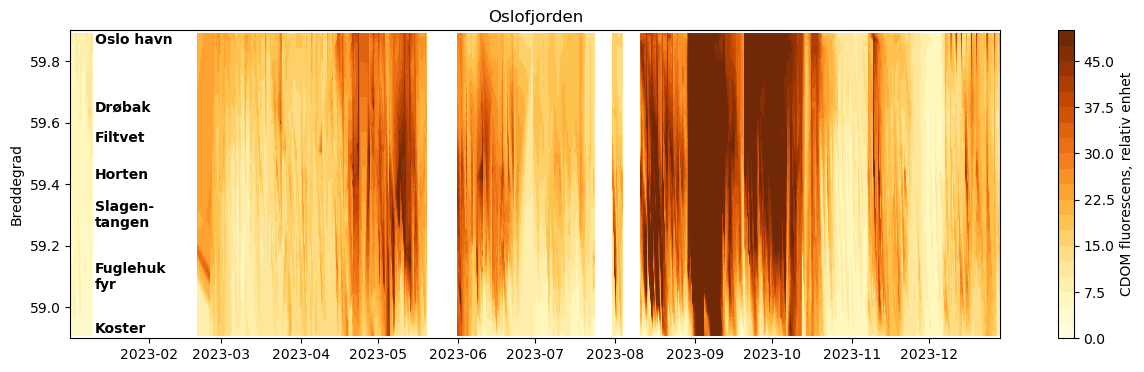

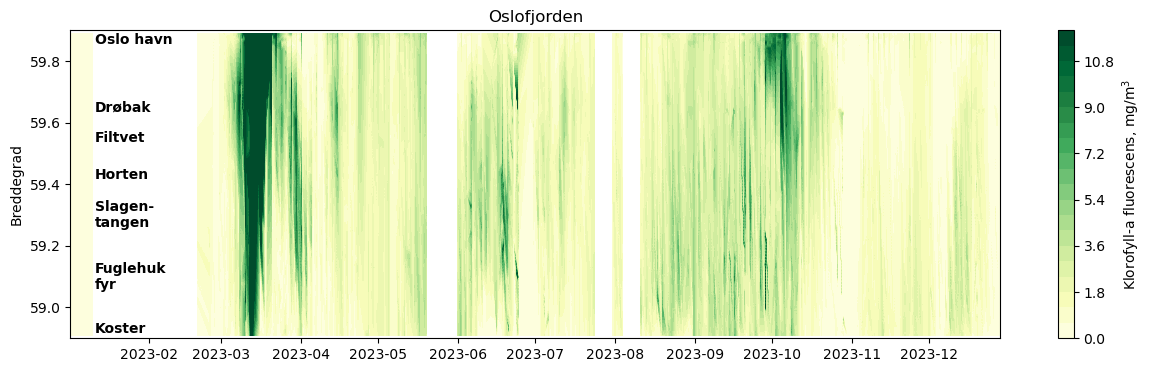

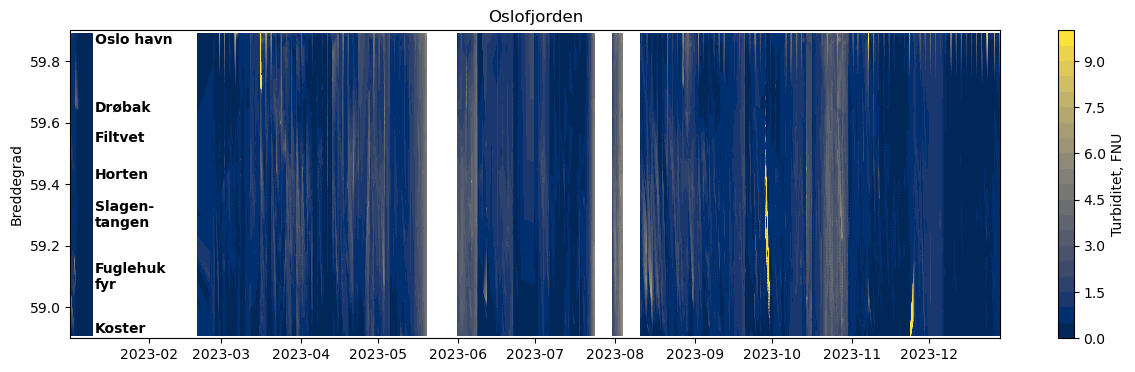

In [31]:
for name in names:
    # contour plot for interpolated data
    fig, ax = plt.subplots(figsize=(15,4))
    
    if name == 'FA/FERRYBOX/SBE45/SALINITY/RAW':
        cf = ax.contourf(dates, lat_reg, ds[fignames[name]], cmap=cmaps[name], levels=np.linspace(8,32,25))
    else:
        cf = ax.contourf(dates, lat_reg, ds[fignames[name]], cmap=cmaps[name], levels=20)
    ax.set_title('Oslofjorden')
    ax.set_ylabel('Breddegrad')
    # ax.set_xlim(pd.to_datetime('2022-06-01'), pd.to_datetime('2023-01-01'))
    cbar = fig.colorbar(cf, label=labels[name])
    
    ax.text(pd.to_datetime('2023-01-11'), 59.87, 'Oslo havn', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-11'), 59.65, 'Drøbak', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-11'), 59.55, 'Filtvet', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-11'), 59.43, 'Horten', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-11'), 59.3, 'Slagen-\ntangen', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-11'), 59.1, 'Fuglehuk\nfyr', fontweight='bold', va='center')
    ax.text(pd.to_datetime('2023-01-11'), 58.93, 'Koster', fontweight='bold', va='center')
    
    plt.savefig(fignames[name] + '_filtered2023', dpi=300, bbox_inches='tight')